# Experiments with projective transforms

This Notebook is needed to get acquainted with projective transforms in Scikit-image.

In [1]:
# Necessary includes

# Scikit-image (for image storing)
from skimage import io
from skimage import transform
# NumPy (for fast vectorised computations)
import numpy as np
# Math (for trigonometry)
from math import cos, sin
# Matplotlib (for inline image rendering)
import matplotlib.pyplot as plot

In [2]:
# Experimental placeholder IM_PATH
#
# Needs to be replaced with a varibale set by end user
# in production version of the program

IM_PATH = '../sample_images/Moscow.jpg'

## Auxiliary toolset

In [3]:
def render_image(image, grayscale=False):
    plot.figure(figsize=(10, 10))
    if grayscale:
        plot.imshow(image, cmap=plot.cm.gray)
    else:
        plot.imshow(image)
    return

## Step 1. Image load

In [4]:
image = io.imread(IM_PATH)

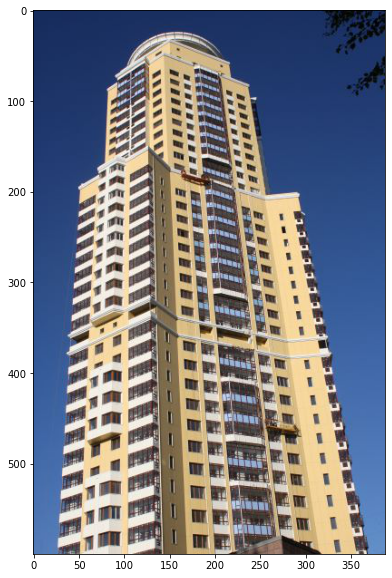

In [5]:
render_image(image)

Vanishing points detected with Hough transforms.

In [6]:
v_h, v_v = (484, 1490), (-676, 116)

## Step 2. Estimate the focal length

We will use estimation based on the length of image diagonal in pixels (see, e.g., [A. Gallagher, 2005] (Kodak, http://chenlab.ece.cornell.edu/people/Andy/publications/Andy_files/rotation_crv2005.pdf)).

In [7]:
focal_length = int((image.shape[0]**2 + image.shape[1]**2)**.5)

In [8]:
focal_length

714

## Step 3. Test of transforms

We need to translate the image such that its origin lies on the intersection of the vertical line going through the vertical vanishing point and the horizontal line going through the horizontal vanishing point.

Chain of transforms:

origin shift $\rightarrow$ from 2D to 3D with $z = $ focal length $\rightarrow$ rotate $\rightarrow$ from 3D to 2D $\rightarrow$ inversed origin shift.

In [9]:
# 1. Shift the origin of the image
#    [3 x 3]
origin_shift = np.array([[1, 0, -v_v[1]],
                         [0, 1, -v_h[0]],
                         [0, 0,   1   ]])

# 2. Go from uniform 2D to uniform 3D: (x, y, 1) -> (x, y, focal length, 1)
#    [4 x 3]
dim_shift_2to3 = np.array([[1, 0,      0      ],
                           [0, 1,      0      ],
                           [0, 0, focal_length],
                           [0, 0,      1      ]])

# 3. Spin the world about the X axis by 0.5 radians
#    [4 x 4]
spin_x = np.array([[1,    0    ,     0    , 0],
                   [0, cos(0.5), -sin(0.5), 0],
                   [0, sin(0.5),  cos(0.5), 0],
                   [0,    0    ,     0    , 1]])

# 4. Spin the world about the Y axis by 0 radians
#    [4 x 4]
spin_y = np.array([[ cos(0), 0, sin(0), 0],
                   [   0   , 1,   0   , 0],
                   [-sin(0), 0, cos(0), 0],
                   [0      , 0,   0   , 1]])

# 5. Go from uniform 3D to uniform 2D: (x, y, z, 1) -> (x, y, 1)
#    [3 x 4]
dim_shift_3to2 = np.array([[1, 0,        0        , 0],
                           [0, 1,        0        , 0],
                           [0, 0, focal_length**-1, 0]])

# 6. Shift the origin back
#    [3 x 3]
inv_origin_shift = np.array([[1, 0, v_v[1]],
                             [0, 1, v_h[0]],
                             [0, 0,   1   ]])

In [10]:
# Resulting transform matrix
# [3 x 3] x [3 x 4] x [4 x 4] x [4 x 4] x [4 x 3] x [3 x 3] = [3 x 3]
transform_matrix = inv_origin_shift @ dim_shift_3to2 @ spin_y @ spin_x @ dim_shift_2to3 @ origin_shift

In [11]:
transform_matrix

array([[ 1.00000000e+00,  7.78898634e-02, -5.18991167e+01],
       [ 0.00000000e+00,  1.20257130e+00, -4.99604385e+02],
       [ 0.00000000e+00,  6.71464340e-04,  5.52593821e-01]])

In [12]:
major_transform = transform.EuclideanTransform(matrix=transform_matrix)

Let us also transform the image in a way so that it fits the borders.

In [56]:
# Initial corner points of the image
corner_tl_orig = np.array([[0], [0], [1]])
corner_tr_orig = np.array([[0], [image.shape[0] - 1], [1]])
corner_bl_orig = np.array([[image.shape[1] - 1], [0], [1]])
corner_br_orig = np.array([[image.shape[1] - 1], [image.shape[0] - 1], [1]])
# Transformed points
corner_tl_trans = transform_matrix @ corner_tl_orig
corner_tr_trans = transform_matrix @ corner_tr_orig
corner_bl_trans = transform_matrix @ corner_bl_orig
corner_br_trans = transform_matrix @ corner_br_orig
corners_trans = np.hstack([corner_tl_trans, corner_tr_trans, corner_bl_trans, corner_br_trans])
corners_trans[[0, 1]] = corners_trans[[1, 0]]
# Bounding box
bbox_tl = np.array([[np.min(corners_trans[0, :] / corners_trans[2, :])], [np.min(corners_trans[1, :] / corners_trans[2, :])]])
bbox_tr = np.array([[np.min(corners_trans[0, :] / corners_trans[2, :])], [np.max(corners_trans[1, :] / corners_trans[2, :])]])
bbox_bl = np.array([[np.max(corners_trans[0, :] / corners_trans[2, :])], [np.min(corners_trans[1, :] / corners_trans[2, :])]])
bbox_br = np.array([[np.max(corners_trans[0, :] / corners_trans[2, :])], [np.max(corners_trans[1, :] / corners_trans[2, :])]])
bbox_width = bbox_tr[1][0] - bbox_tl[1][0]
bbox_height = bbox_br[0][0] - bbox_tr[0][0]
#print(bbox_tl)
#print(bbox_tr)
#print(bbox_bl)
#print(bbox_br)

# Translation
fit_border_translation = np.array([[1, 0, -bbox_tl[1][0]],
                                   [0, 1, -bbox_tl[0][0]],
                                   [0, 0,        1     ]])
# Scale
fit_border_scale = np.array([[image.shape[1] / bbox_width,               0             , 0],
                             [             0             , image.shape[0] / bbox_height, 0],
                             [             0             ,               0             , 1]])

# 7. Fit the borders
fit_border_matrix = fit_border_scale @ fit_border_translation

In [57]:
fit_border_matrix

array([[  0.55402171,   0.        ,  52.03322296],
       [  0.        ,   0.52849794, 477.81911203],
       [  0.        ,   0.        ,   1.        ]])

In [58]:
fit_border_transform = transform.EuclideanTransform(matrix=fit_border_matrix)

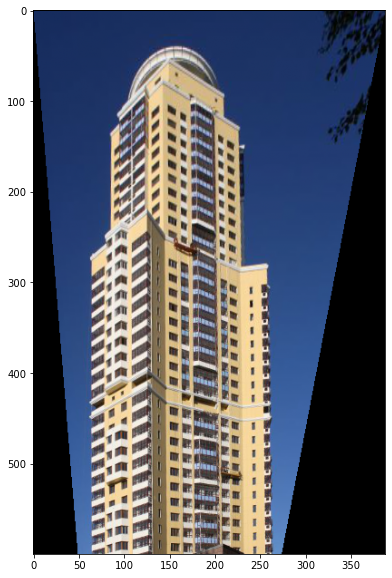

In [59]:
render_image(transform.warp(image, (major_transform + fit_border_transform).inverse))